## Dependencies:

In [2]:
import json
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from adjustText import adjust_text
from collections import OrderedDict
import statistics

## Load data:

In [3]:
with open('../data/run.json') as f:
    data = json.load(f)
    
audit = []
for line in open('../data/audits.json', 'r'):
    audit.append(json.loads(line))

## Prototype number crunching:

In [45]:
uid_to_token = dict()
item_to_existing_uid = dict()
for audit_log in audit:
    if audit_log['type'] == 'PREPARE_JUDGEMENT':
        uid_to_token[audit_log['submission']['uid']] = audit_log['token']
        if audit_log['submission']['uid'] not in item_to_existing_uid:
            item_to_existing_uid[audit_log['submission']['item']['id'] + '-' + str(audit_log['submission']['start'])] = audit_log['submission']['uid']
        
token_to_judgeId = dict()
for audit_log in audit:
    if audit_log['type'] == 'JUDGEMENT':
        token_to_judgeId[audit_log['token']] = audit_log['user']
        
user_to_judge_name = dict()
for audit_log in audit:
    if audit_log['type'] == 'LOGIN':
        if 'judge' in audit_log['user']:
            user_to_judge_name[audit_log['session']] = audit_log['user']
            
uid_to_judge_name = dict()
for uid in uid_to_token.keys():
    if uid_to_token[uid] in token_to_judgeId:
        uid_to_judge_name[uid] = user_to_judge_name[token_to_judgeId[uid_to_token[uid]]]
        
        
item_to_judge = dict()
for audit_log in audit:
    if audit_log['type'] == 'SUBMISSION':
        if audit_log['submission']['uid'] in uid_to_judge_name:
            item = audit_log['submission']['item']['id'] + '-' + str(audit_log['submission']['start'])
            item_to_judge[item] = uid_to_judge_name[item_to_existing_uid[item]]


## Additional data loading:

In [48]:
v3c1_ids = dict()

with open('../data/v3c1_segments.csv', mode='r') as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        if row[0] not in v3c1_ids:
            v3c1_ids[row[0]] = dict()
        v3c1_ids[row[0]][row[2]] = row[1]

class Shot:
    def __init__(self, shotStart, shotEnd, segmentId):
        self.shotStart = int(shotStart)
        self.shotEnd = int(shotEnd)
        self.segmentId = int(segmentId)
        
    def isWithin(self, shotId):
        return shotId >= self.shotStart and shotId <= self.shotEnd
    
    def get_segmentId(self):
        return self.segmentId
        
v3c1_ids_shots = dict()
with open('../data/v3_c1_frame_segments.csv', mode='r') as infile:
    reader = csv.reader(infile)
    is_header = True
    for row in reader:
        if is_header:
            is_header = False
            continue
        if row[0] not in v3c1_ids_shots:
            v3c1_ids_shots[row[0]] = []
        v3c1_ids_shots[row[0]].append(Shot(row[3], row[5], row[1]))

judge_dict = dict()
node_dict = dict()
with open('../data/judgements.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for row in reader:
        judge_dict[row[4]] = row[3]
        node_dict[row[4]] = row[1]

## Export judgement csv:

Necessary data to load: 
- Dependencies
- Load data
- Additional data loading

In [47]:
avs_list = []

error_list = []

for task in data['tasks']:
    if task['description']['taskGroup']['name'] == 'AVS':
        for submission in task['submissions']:
            try:
                row = dict()
                row['timestamp'] = submission['timestamp']
                row['videoId'] = submission['item']['name']
                row['shotId'] = v3c1_ids[submission['item']['name']][str(int(submission['temporalRange']['start']['value']))]
                row['userId'] = submission['memberId']
                row['taskId'] = task['taskDescriptionId']
                row['judgeId'] = item_to_judge[submission['item']['id'] + '-' + str(int(submission['temporalRange']['start']['value']))]
                row['correct'] = True if submission['status'] == 'CORRECT' else False
                avs_list.append(row)
            except KeyError:
                error_list.append(submission['uid'])

avs_list

df_error = pd.DataFrame(error_list)
df_error.to_csv('./csv/error_list.csv')
df = pd.DataFrame(avs_list)
df.to_csv('./csv/avs_judging.csv')

## Helper classes:

#### Submission: Store a submission with all the necessary information regarding a submission from the JSON

In [5]:
class Submission:
    
    def __init__(self, memberId, status, teamId, uid, timestamp, itemName):
        self.memberId = memberId
        self.status = status
        self.teamId = teamId
        self.uid = uid
        self.timestamp = timestamp
        self.itemName = itemName
        
    def is_correct(self):
        return self.status == 'CORRECT'
        
    def __lt__(self, other):
         return self.timestamp < other.timestamp

#### TaskCount: Count and store the number of Correct or Incorrect to a task

In [6]:
class TaskCount:
    
    def __init__(self):
        self.correct = 0
        self.incorrect = 0
        
    def add_status(self, status):
        if status == 'CORRECT':
            self.add_correct()
        elif status == 'WRONG':
            self.add_incorrect()
        
    def add_correct(self):
        self.correct += 1
        
    def add_incorrect(self):
        self.incorrect += 1
        
    def get_incorrect(self):
        if self.incorrect > 0:
            return self.incorrect
        elif self.correct > 0:
            return -1
        else:
            return 0
        
    def __str__(self):
        return 'correct: ' + str(self.correct) + ' incorrect: ' + str(self.incorrect)

#### Team: Store all the necessary information of a team and transform the stored data to a df for latex export

In [7]:
class Team:
    
    def __init__(self, teamId, name):
        self.teamId = teamId
        self.name = name
        self.tasksDicts = dict()
        self.tasksDicts['KIS-Visual'] = dict()
        self.tasksDicts['KIS-Textual'] = dict()
        self.tasksDicts['AVS'] = dict()
        self.avsTasksList = dict()
        
    def get_name(self):
        return self.name
        
    def add_avs_task(self, task, index):
        self.avsTasksList[index] = task
        
    def get_avs_task(self, index):
        return self.avsTasksList[index]
    
    def add_avs_submission(self, index, memberId, status, teamId, uid, timestamp, itemName):
        self.avsTasksList[index].add_submission(memberId, status, teamId, uid, timestamp, itemName)
    
    def add_task(self, position, status, task_type):
        if position in self.tasksDicts[task_type]:
            self.tasksDicts[task_type][position].add_status(status)
        else:
            tc = TaskCount()
            tc.add_status(status)
            self.tasksDicts[task_type][position] = tc
            
    def to_df(self):
        data_dict = OrderedDict()
        total_sum = 0
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Textual']):
            value = self.tasksDicts['KIS-Textual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            if str_val == '0':
                str_val = '-1'
            data_dict['T_' + str(key)] = str_val
        data_dict['Sigma1'] = sumup
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Visual']):
            value = self.tasksDicts['KIS-Visual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            if str_val == '0':
                str_val = '-1'
            data_dict['V_' + str(key)] = str_val
        data_dict['Sigma2'] = sumup
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['AVS']):
            value = self.tasksDicts['AVS'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            if str_val == '0':
                str_val = '-1'
            data_dict['A_' + str(key)] = str_val
        data_dict['Sigma3'] = sumup
        total_sum += sumup
        data_dict['Sigma4'] = total_sum
        df = pd.DataFrame(data=data_dict, index=[self.name])
        return df
            
    def print_incorrect(self):
        print(self.name + ' | ', end='')
        total_sum = 0
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Textual']):
            value = self.tasksDicts['KIS-Textual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            print(str_val + ' | ', end='')
        print('Sum: ' + str(sumup) + ' | ', end='')
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['KIS-Visual']):
            value = self.tasksDicts['KIS-Visual'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            print(str_val + ' | ', end='')
        print('Sum: ' + str(sumup) + ' | ', end='')
        total_sum += sumup
        sumup = 0
        for key in sorted(self.tasksDicts['AVS']):
            value = self.tasksDicts['AVS'][key].get_incorrect()
            str_val = str(value)
            if value < 0:
                value = 0
            sumup += value
            if str_val == '-1':
                str_val = ' '
            print(str_val + ' | ', end='')
        print('Sum: ' + str(sumup) + ' | ')
        total_sum += sumup
        print('Total Sum: ' + str(total_sum))

#### Task: Store all the necessary information to a task as well as optional additional information for various data crunching

In [114]:
class Task:
    
    def __init__(self, started, ended, duration, position, uid, taskType):
        self.best_logged_rank_video = float('inf')
        self.best_logged_rank_shot = float('inf')
        self.best_logged_time_video = -1
        self.best_logged_time_shot = -1
        self.correct_submission_time = -1
        self.submissions = []
        self.started = started
        self.ended = ended
        self.duration = duration
        self.position = position
        self.uid = uid
        self.taskType = taskType
        self.correct_video = -1
        self.correct_shot = -1
        self.name = ''
        
    def add_name(self, name):
        self.name = name
        
    def add_submission(self, memberId, status, teamId, uid, timestamp, itemName):
        submission = Submission(memberId, status, teamId, uid, timestamp, itemName)
        self.submissions.append(submission)
        self.submissions.sort()
        
    def get_total_submissions(self):
        return len(self.submissions)
    
    def get_correct_submissions(self):
        count = 0
        for sub in self.submissions:
            if sub.is_correct():
                count += 1
        return count
    
    def get_correct_video_submissions(self):
        videos = dict()
        for sub in self.submissions:
            if sub.is_correct():
                videos[sub.itemName] = ''
        return len(videos.keys())
    
    def get_incorrect_or_indeterminate_submissions(self):
        count = 0
        for sub in self.submissions:
            if not sub.is_correct():
                count += 1
        return count
    
    def get_precision(self):
        if self.get_incorrect_or_indeterminate_submissions() == 0 and self.get_correct_submissions() == 0:
            return None
        elif self.get_incorrect_or_indeterminate_submissions() == 0:
            return 1
        return self.get_correct_submissions() / (self.get_correct_submissions() + self.get_incorrect_or_indeterminate_submissions())
            
    def timestamp_within(self, timestamp):
        return timestamp >= self.started and timestamp <= self.ended
    
    def get_logged_time(self, logged_time):
        return (logged_time - self.started) / 1000
    
    def add_new_ranking(self, results, adjusted_logged_time, vitrivr=False, visione=False, somHunter=False, viret=False, diveXplore=False):
        for index, result in enumerate(results):
            if vitrivr or diveXplore:
                videoId = result['item'][2:]
            else:
                videoId = result['item']
            
            if visione:
                shotId = result['frame']
            elif somHunter or viret or diveXplore:
                for segment in v3c1_ids_shots[videoId]:
                    if segment.isWithin(int(result['frame'])):
                        shotId = segment.get_segmentId()
                        break
            else:
                shotId = result['segment']
            #print('videoId: ' + str(videoId) + ' shotId: ' + str(shotId))
            if shotId is None:
                continue
            if videoId == self.correct_video:
                if result['rank'] is None:
                        rank = 0
                else:
                    rank = result['rank']
                if somHunter:
                    rank = index
                if shotId == self.correct_shot:
                    if rank < self.best_logged_rank_shot and (adjusted_logged_time <= self.correct_submission_time or self.correct_submission_time < 0):
                        self.best_logged_rank_shot = rank
                        self.best_logged_time_shot = adjusted_logged_time
                if rank < self.best_logged_rank_video and (adjusted_logged_time <= self.correct_submission_time or self.correct_submission_time < 0):
                    self.best_logged_rank_video = rank
                    self.best_logged_time_video = adjusted_logged_time
                    
    def add_correct_submission_time(self, cst):
        self.correct_submission_time = (cst - self.started) / 1000
        
    def get_name(self):
        return self.name
    
    def add_correct_shot_and_video(self, shotId, videoId):
        self.correct_video = videoId
        self.correct_shot = int(shotId)
        
    def get_rel_info(self, rank_zero=False):
        if rank_zero:
            best_rank_shot = self.best_logged_rank_shot + 1
            best_rank_video = self.best_logged_rank_video + 1
        else:
            best_rank_shot = self.best_logged_rank_shot
            best_rank_video = self.best_logged_rank_video
        if self.best_logged_time_shot == -1:
            best_ranked_time = self.best_logged_time_video
        else:
            best_ranked_time = self.best_logged_time_shot
        return best_rank_shot, best_rank_video, best_ranked_time, self.correct_submission_time
        
    def get_bins(self, nr_bins):
        interval = (self.ended - self.started) / nr_bins
        correct = [0] * nr_bins
        incorrect = [0] * nr_bins
        curr_low = self.started
        curr_high = self.started + interval
        index = 0
        
        for submission in self.submissions:
            if submission.timestamp > curr_high:
                index += 1
                curr_low = curr_high
                curr_high = curr_high + interval
            if submission.status == 'CORRECT':
                correct[index] += 1
            else:
                incorrect[index] += 1
          
        result_bins = [0] * nr_bins
        for i in range(0, nr_bins):
            total = correct[i] + incorrect[i]
            # TODO: How to handle if there are no entries?
            if total == 0:
                result_bins[i] = 0
            else:
                result_bins[i] = correct[i] / total
        return result_bins
    
    def get_number_of_submissions_in_bins(self, nr_bins):
        interval = (self.ended - self.started) / nr_bins
        number_of_submissions = [0] * nr_bins
        curr_low = self.started
        curr_high = self.started + interval
        index = 0
        
        for submission in self.submissions:
            if submission.timestamp > curr_high:
                    index += 1
                    curr_low = curr_high
                    curr_high = curr_high + interval
            number_of_submissions[index] += 1
        return number_of_submissions
        

## Precision over time:

Necessary data to load: 
- Dependencies
- Load data
- Submission

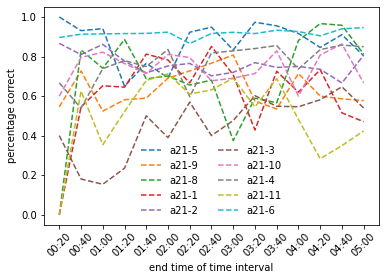

In [8]:
nr_bins = 15

tasks = []
task_names = []
times = ['00:20', '00:40', '01:00', '01:20', '01:40', '02:00', '02:20', '02:40', '03:00', '03:20', '03:40', '04:00', '04:20', '04:40', '05:00']

for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        task_names.append(t['description']['name'])
        task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
        for s in t['submissions']:
            task.add_submission(s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
        tasks.append(task)
        
bins = []

for t in tasks:
    calculated_bin = t.get_bins(nr_bins)
    bins.append(calculated_bin)
    
average_bin = [0] * len(bins[0])
for b in bins:
    average_bin = [x + y for x, y in zip(average_bin, b)]
average_bin = [x / len(bins) for x in average_bin]

transposed_list = list(map(list, zip(*bins)))

for i in range(len(bins)):
    plt.plot(times,bins[i],label = '%s'%task_names[i], linestyle='dashed')

plt.ylabel('percentage correct')
plt.xlabel('end time of time interval')
plt.xticks(rotation=45)
plt.legend(frameon=False, loc='lower center', ncol=2)
plt.savefig('figs/precision_over_time.pdf', format='pdf', bbox_inches="tight")

## Fig. 2 reconstruction:

In [9]:
teams = dict()
team_columns = ['vitrivr', 'VIRET', 'Vireo', 'SomHunter', 'HTW', 'SIRET', 'vitrivr-vr', 'VERGE', 'VBS2020 Winner', 'Exquisitor', 'VISIONE', 'diveXplore', 'VideoGraph', 'noshot', 'IVIST', 'IVOS', 'EOLAS']

for t in data['description']['teams']:
    teams[t['uid']] = Team(t['uid'], t['name'])

for task in data['tasks']:
    for submission in task['submissions']:
        teams[submission['teamId']].add_task(task['position'], submission['status'], task['description']['taskGroup']['name'])
      
df_list = []    
        
for team in teams:
    df_list.append(teams[team].to_df())
    
df = pd.concat(df_list)
df = df.fillna(-1)
cols = df.columns.tolist()
cols.insert(11, cols.pop(34))
cols.insert(16, cols.pop(35))
cols.insert(20, cols.pop(36))
cols.insert(2, cols.pop(37))
cols.insert(24, cols.pop(38))
cols.insert(5, cols.pop(39))
cols.insert(16, cols.pop(40))

df = df[cols]

df = df.T
df = df[team_columns]

df.to_csv('./csv/nr_incorrect.csv')

df.to_latex('./tex/nr_incorrect.tex')

## Fig. 3 reconstruction:

In [115]:
def get_team_values_df(team, rank_zero, path_to_team='../data/logged_rankings/'):
    tasks = []

    teamId = ''

    teamName = team
    
    if teamName == 'SOMHunter':
        teamName = 'SomHunter'
    elif teamName == 'LegacySOMHunter':
        teamName = 'VBS2020 Winner'
    elif teamName == 'CollageHunter':
        teamName = 'SIRET'
    elif teamName == 'viret':
        teamName = 'VIRET'
    
    for t in data['description']['teams']:
        if t['name'] == teamName:
            teamId = t['uid']
            break

    for t in data['tasks']:
        if t['description']['taskType']['name'] == 'Visual KIS' or t['description']['taskType']['name'] == 'Textual KIS':
            task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskType']['name'])
            task.add_name(t['description']['name'])
            cst = -1
            for s in t['submissions']:
                if s['status'] == 'CORRECT' and s['teamId'] == teamId:
                    cst = s['timestamp']
                    break
            task.add_correct_submission_time(cst)
            videoId = t['description']['target']['item']['name']
            timeshot = int(t['description']['target']['temporalRange']['start']['value'] * 1000)
            shotId = -1
            sorted_list = list(map(int, v3c1_ids[videoId].keys()))
            next_key = 0
            for k in sorted_list:
                iter_key = next_key
                next_key = k
                if timeshot >= iter_key and timeshot < next_key:
                    shotId = v3c1_ids[videoId][str(iter_key)]
                    break
            task.add_correct_shot_and_video(shotId, videoId)
            tasks.append(task)

    for root, _, files in os.walk(path_to_team + team):
        for file in files:
            path = os.path.join(root, file)
            if file == '.DS_Store':
                continue
            with open(path) as f:
                ranked_list = json.load(f)
                timestamp = int(os.path.splitext(file)[0])
                for task in tasks:
                    if task.timestamp_within(timestamp):
                        adj_logged_time = task.get_logged_time(timestamp)
                        vitrivr = team == 'vitrivr' or team == 'vitrivr-vr' or team == 'Vireo'
                        visione = team == 'VISIONE'
                        somHunter = team == 'CollageHunter' or team == 'LegacySOMHunter' or team == 'SOMHunter'
                        viret = team == 'viret'
                        diveXplore = team == 'diveXplore'
                        task.add_new_ranking(ranked_list['results'], adj_logged_time, vitrivr, visione, somHunter, viret, diveXplore)
                        break
            

    calc_dict = dict()
    calc_dict['name'] = []
    calc_dict['r_s'] = []
    calc_dict['r_v'] = []
    calc_dict['t'] = []
    calc_dict['t_cs'] = []

    for task in tasks:
        name = task.get_name()
        r_s, r_v, t, t_cs = task.get_rel_info(rank_zero)
        calc_dict['name'].append(name)
        calc_dict['r_s'].append(r_s)
        calc_dict['r_v'].append(r_v)
        calc_dict['t'].append(t)
        calc_dict['t_cs'].append(t_cs)
    df = pd.DataFrame(data=calc_dict, index=calc_dict['name'])
    df = df.drop(columns=['name'])
    df.replace([np.inf, -np.inf], -1, inplace=True)
    df = df.astype('int32')
    df[df < 0] = -1
    df = df.astype('str')
    df.replace(['-1'], '-', inplace=True)
    return df


In [11]:
team = 'vitrivr'
rank_zero = True
df1 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df1.to_csv('./csv/vitrivr_calc.csv')

In [82]:
team = 'vitrivr-vr'
rank_zero = True
df2 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df2.to_csv('./csv/vitrivr_vr_calc.csv')

443d8be7-e381-4fbd-ba46-ff2514db3117


In [83]:
team = 'VideoGraph'
rank_zero = True
df3 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df3.to_csv('./csv/videoGraph_calc.csv')


a265bf53-7e8c-4122-92bc-ee38772d1058


In [101]:
team = 'VERGE'
rank_zero = True
df4 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df4.to_csv('./csv/VERGE_calc.csv')

4449ae20-04f9-44dc-aed2-cec6330c3e83


In [85]:
team = 'VISIONE'
rank_zero = False
df5 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df5.to_csv('./csv/VISIONE_calc.csv')


7bf90d4b-a2e6-49db-b7af-b7dbb91d01e7


In [90]:
team = 'viret'
rank_zero = True
df6 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df6.to_csv('./csv/viret_calc.csv')

f43dc2f2-0e0b-40d8-bfb0-f019bc895b5b


In [89]:
team = 'CollageHunter'
rank_zero = True
df7 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/dres/')
df7.to_csv('./csv/CollageHunter_calc.csv')

b231f852-86ea-4f7f-84bd-b2f87a94e467


In [88]:
team = 'LegacySOMHunter'
rank_zero = True
df8 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/dres/')
df8.to_csv('./csv/LegacySOMHunter_calc.csv')

0a2860d2-b2c9-4fe5-adc2-c02534b25911


In [87]:
team = 'SOMHunter'
rank_zero = True
df9 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/dres/')
df9.to_csv('./csv/SOMHunter_calc.csv')

c69fbcda-041c-458f-b4e7-5e2e3c1f9489


In [86]:
team = 'Vireo'
rank_zero = True
df10 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df10.to_csv('./csv/Vireo_calc.csv')

b11e55a0-caed-4001-9e03-11b05b38288b


In [116]:
team = 'diveXplore'
rank_zero = True
df11 = get_team_values_df(team, rank_zero, '/Volumes/F-A23/')
df11.to_csv('./csv/diveXplore_calc.csv')

## Create latex from calculations

Warning: First execute the corresponding Dataframe creations!

In [113]:
total_df = pd.concat([df1, df6], axis=1)
total_df = pd.concat([total_df, df10], axis=1)
total_df = pd.concat([total_df, df9], axis=1)
total_df = pd.concat([total_df, df7], axis=1)
total_df = pd.concat([total_df, df2], axis=1)
total_df = pd.concat([total_df, df4], axis=1)
total_df = pd.concat([total_df, df8], axis=1)
total_df = pd.concat([total_df, df5], axis=1)
total_df = pd.concat([total_df, df3], axis=1)
total_df = total_df.T
total_df.to_csv('./csv/total_calc.csv')
total_df.to_latex('./tex/total_calc.tex')

NameError: name 'df1' is not defined

## AVS submissions over time:

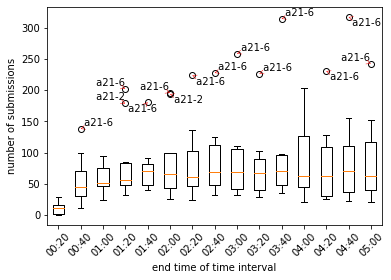

In [12]:
nr_bins = 15

times = ['00:20', '00:40', '01:00', '01:20', '01:40', '02:00', '02:20', '02:40', '03:00', '03:20', '03:40', '04:00', '04:20', '04:40', '05:00']
tasks = []

for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
        task.add_name(t['description']['name'])
        for s in t['submissions']:
            task.add_submission(s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
        tasks.append(task)
        
bins = []
task_names = []

for t in tasks:
    calculated_bin = t.get_number_of_submissions_in_bins(nr_bins)
    bins.append(calculated_bin)
    task_names.append(t.get_name())
    
average_bin = [0] * len(bins[0])
for b in bins:
    average_bin = [x + y for x, y in zip(average_bin, b)]

average_bin = [x / len(bins) for x in average_bin]

transposed_list = list(map(list, zip(*bins)))

q1_list = []
q3_list = []
for l in transposed_list:
    q1_list.append(np.quantile(l, 0.25))
    q3_list.append(np.quantile(l, 0.75))
    
iqr = []
for i in range(len(q3_list)):
    iqr.append(q3_list[i] - q1_list[i])

upper_bound = []
lower_bound = []

for i in range(len(iqr)):
    upper_bound.append(q3_list[i]+(1.5*iqr[i]))
    lower_bound.append(q1_list[i]-(1.5*iqr[i]))

plt.boxplot(transposed_list)
plt.ylabel('number of submissions')
plt.xlabel('end time of time interval')
plt.xticks(rotation=45)
plt.xticks([i + 1 for i in range(15)], times)
texts = []
for i in range(len(transposed_list)):
    for index, val in enumerate(transposed_list[i]):
        if val > upper_bound[i] or val < lower_bound[i]:
            texts.append(plt.text(i + 1, val, f' {task_names[index]}'))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.savefig('figs/avs_submissions_over_time.pdf', format='pdf', bbox_inches="tight")

## VBS Submissions over tasks

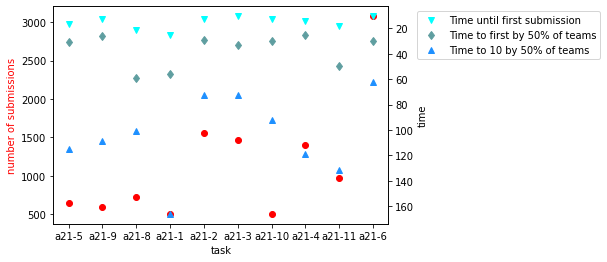

In [106]:
nr_bins = 15

tasks = []

for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
        task.add_name(t['description']['name'])
        for s in t['submissions']:
            task.add_submission(s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
        tasks.append(task)

bins = OrderedDict()

for t in tasks:
    calculated_bin = t.get_number_of_submissions_in_bins(nr_bins)
    bins[t.get_name()] = calculated_bin
    
df = pd.DataFrame(data=bins)

df = df.T
df = df.sum(axis = 1, skipna = True)
#df = df.sort_index()
df = df.to_frame()
#idx = df.index.tolist()
#id1 = idx.pop(1)
#idx.append(id1)
#id1 = idx.pop(1)
#idx.append(id1)
#df = df.reindex(idx)


#avs_tasks_stats['Time to first Submission'] = []
#avs_tasks_stats['Time to first by 50% of teams'] = []
#avs_tasks_stats['Time to 10 by 50% of teams'] = []
fig = plt.figure()
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax2.plot(df.reset_index().index, avs_tasks_stats['Time to first Submission'], 'v', label="Time until first submission", color='aqua')
ax2.plot(df.reset_index().index, avs_tasks_stats['Time to first by 50% of teams'], 'd', label="Time to first by 50% of teams", color='cadetblue')
ax2.plot(df.reset_index().index, avs_tasks_stats['Time to 10 by 50% of teams'], '^', label="Time to 10 by 50% of teams", color='dodgerblue')
ax1.scatter(df.reset_index().index, df[0].tolist(), color='red')
ax1.set_ylabel('number of submissions', color='red')
ax2.set_ylabel('time')
ax2.invert_yaxis()
ax1.set_xlabel('task')
plt.xticks(df.reset_index().index, df.reset_index()['index'], rotation=90)
#ax.set_yscale('log')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.07, 1), loc='upper left')
plt.savefig('figs/vbs_submissions_over_tasks.pdf', format='pdf', bbox_inches="tight")


## Precision/Recall and other metrics table:

In [14]:
teams = dict()
recall_total = dict()
video_recall = dict()

for t in data['description']['teams']:
    teams[t['uid']] = Team(t['uid'], t['name'])
    
index = 0
for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        recall_total[t['description']['name']] = dict()
        video_recall[t['description']['name']] = dict()
        for k in teams.keys():
            task = Task(t['started'], t['ended'], t['duration'], t['position'], t['uid'], t['description']['taskGroup']['name'])
            task.add_name(t['description']['name'])
            teams[k].add_avs_task(task, index)
        for s in t['submissions']:
            teams[s['teamId']].add_avs_submission(index, s['memberId'], s['status'], s['teamId'], s['uid'], s['timestamp'], s['item']['name'])
            recall_total[t['description']['name']][s['item']['name'] + str(s['temporalRange']['start']['value']) + str(s['temporalRange']['end']['value'])] = 1
            video_recall[t['description']['name']][s['item']['name']] = 1
        index += 1
        
team_dfs = dict()
        
for t in teams:
    teams_dict = dict()
    team = teams[t]
    for i in range(index):
        task = team.get_avs_task(i)
        teams_dict[task.get_name() + 't'] = task.get_correct_submissions()
        teams_dict[task.get_name() + 'f'] = task.get_incorrect_or_indeterminate_submissions()
        teams_dict[task.get_name() + 'prec'] = task.get_precision()
        teams_dict[task.get_name() + 'rec'] = task.get_correct_submissions() / len(recall_total[task.get_name()])
    team_dfs[team.get_name()] = teams_dict
    
df = pd.DataFrame(data=team_dfs)
df = df[team_columns]
df = df.round(3)
df.to_latex('./tex/prec_rec.tex')


## PR Plot

Dependencies:
- Team
- Task
- Fig. 2 reconstruction
- Precision/Recall and other metrics table

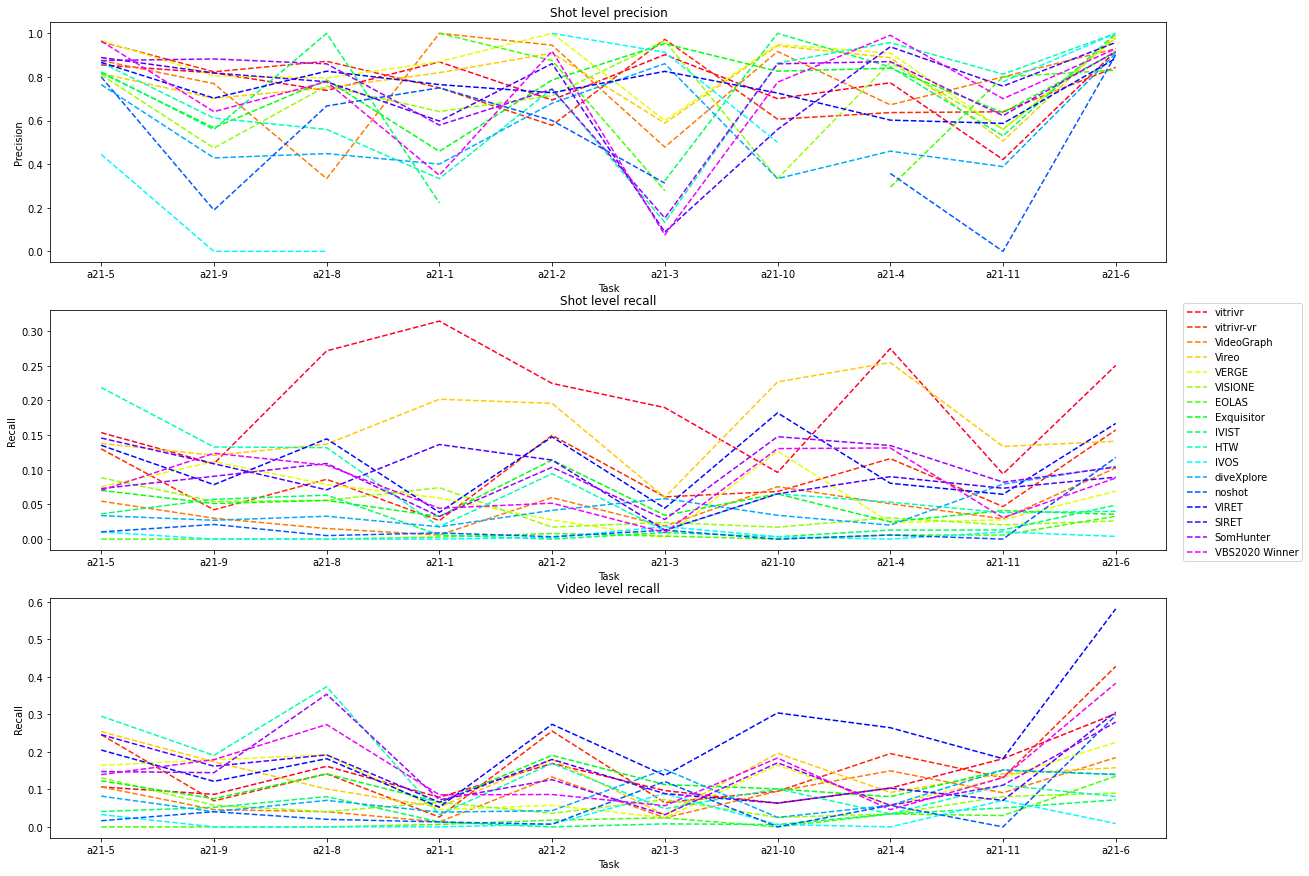

In [15]:
team_names = []
task_names = dict()
precision_total = []
recall_total_2 = []
video_recall_2 = []

for t in teams:
    team = teams[t]
    team_names.append(team.get_name())
    precision = []
    recall = []
    video_recall_inner = []
    for i in range(index):
        task = team.get_avs_task(i)
        task_names[task.get_name()] = 1
        precision.append(task.get_precision())
        recall.append((task.get_correct_submissions() / len(recall_total[task.get_name()])))
        video_recall_inner.append((task.get_correct_video_submissions() / len(video_recall[task.get_name()])))
    precision_total.append(precision)
    recall_total_2.append(recall)
    video_recall_2.append(video_recall_inner)
        
task_names = task_names.keys()

NUM_COLORS = len(team_names)

cm = plt.get_cmap('gist_rainbow')
fig, axs = plt.subplots(3,figsize=(20,15))
axs[0].set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
axs[1].set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
axs[2].set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

axs[0].set_xlabel("Task")
axs[0].set_ylabel("Precision")
axs[0].set_title("Shot level precision")

for i in range(len(precision_total)):
    axs[0].plot(task_names,[pt for pt in precision_total[i]],label = '%s'%team_names[i], linestyle='dashed')

axs[1].set_xlabel("Task")
axs[1].set_ylabel("Recall")
axs[1].set_title("Shot level recall")

for i in range(len(precision_total)):
    axs[1].plot(task_names,[pt for pt in recall_total_2[i]],label = '%s'%team_names[i], linestyle='dashed')

axs[2].set_xlabel("Task")
axs[2].set_ylabel("Recall")
axs[2].set_title("Video level recall")

for i in range(len(precision_total)):
    axs[2].plot(task_names,[pt for pt in video_recall_2[i]],label = '%s'%team_names[i], linestyle='dashed')

    
plt.legend(bbox_to_anchor=(1.01, 2.25), loc='upper left')
    
plt.savefig('figs/precision_recall.pdf', format='pdf', bbox_inches="tight")

## MSB to unified format

WARNING: Only execute if MSB present

In [47]:
def msb_to_unified():
    header = ['video', 'segment', 'start', 'startframe', 'end', 'endframe']

    with open('../data/v3_c1_frame_segments.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        for root, dirs, files in os.walk('../data/msb'):
            sorted_files = sorted(files)
            for file in sorted_files:
                tsv_file = open(root + '/' + file)
                read_tsv = csv.reader(tsv_file, delimiter="\t")
                segmentId = 0
                videoId = os.path.splitext(file)[0]
                for row in read_tsv:
                    if segmentId != 0:
                        write_row = [videoId, segmentId, int(float(row[1]) * 1000), row[0], int(float(row[3]) * 1000), row[2]]
                        writer.writerow(write_row)
                    segmentId += 1


## AVS Task Description Table

In [18]:
pd.set_option('max_colwidth',120)
avs_tasks = dict()
for task in data['tasks']:
    if task['description']['taskGroup']['name'] == 'AVS':
        avs_tasks[task['description']['name']] = task['description']['hints'][0]['text']
df = pd.Series(avs_tasks).to_frame()

df.to_latex('./tex/avs_description.tex')

## AVS Task differences:

In [71]:
avs_tasks_stats = dict()
avs_tasks_stats['task'] = []
avs_tasks_stats['Submissions'] = []
avs_tasks_stats['Time to first Submission'] = []
avs_tasks_stats['Time to first by 50% of teams'] = []
avs_tasks_stats['Time to 10 by 50% of teams'] = []

nr_team = len(data['description']['teams'])

for t in data['tasks']:
    if t['description']['taskGroup']['name'] == 'AVS':
        avs_tasks_stats['task'].append(t['description']['name'])
        avs_tasks_stats['Submissions'].append(len(t['submissions']))
        if len(t['submissions']) > 0:
            avs_tasks_stats['Time to first Submission'].append((t['submissions'][0]['timestamp'] - t['started']) / 1000)
        else:
            avs_tasks_stats['Time to first Submission'].append(-1)
        timestamp_50_1 = -1
        timestamp_50_10 = -1
        ts_50_1 = False
        nr_submissions_teams = dict()
        for submission in t['submissions']:
            if submission['teamId'] not in nr_submissions_teams:
                nr_submissions_teams[submission['teamId']] = 1
            else:
                nr_submissions_teams[submission['teamId']] += 1
            if len(nr_submissions_teams) >= 0.5 * nr_team and not ts_50_1:
                ts_50_1 = True
                timestamp_50_1 = (submission['timestamp'] - t['started']) / 1000
            nr_over_10 = 0
            for s in nr_submissions_teams:
                if nr_submissions_teams[s] >= 10:
                    nr_over_10 += 1
            if nr_over_10 >= 0.5 * nr_team:
                timestamp_50_10 = (submission['timestamp'] - t['started']) / 1000
                break
        avs_tasks_stats['Time to first by 50% of teams'].append(timestamp_50_1)
        avs_tasks_stats['Time to 10 by 50% of teams'].append(timestamp_50_10)

df = pd.DataFrame(data=avs_tasks_stats, index=avs_tasks_stats['task'])
df.to_latex('./tex/avs_differences.tex')


## Aggregate statistics

In [21]:
teams = dict()

for t in data['description']['teams']:
    teams[t['uid']] = Team(t['uid'], t['name'])

team_uids = teams.keys()

percentages_solved = []
p_s = dict()

for task in data['tasks']:
    if task['description']['taskGroup']['name'] == 'KIS-Textual' or task['description']['taskGroup']['name'] == 'KIS-Visual':
        local_teams = dict()
        for s in task['submissions']:
            if s['status'] == 'CORRECT':
                local_teams[s['teamId']] = True
        percentage_solved = len(local_teams.keys()) / len(team_uids)

        percentages_solved.append(percentage_solved)
        p_s[task['description']['name']] = percentage_solved * 100

print('Max: ' + str(max(percentages_solved) * 100))
print('Min: ' + str(min(percentages_solved) * 100))
print('Mean: ' + str(statistics.mean(percentages_solved) * 100))
print('Median: ' + str(statistics.median(percentages_solved) * 100))

df = pd.Series(p_s).to_frame()
df = df.astype('int32')
df.to_latex('./tex/task_solved.tex')


Max: 94.11764705882352
Min: 0.0
Mean: 55.773420479302835
Median: 58.82352941176471


## Timedelta first found and submit

In [159]:
def get_team_deltas(team, path_to_team='/Volumes/F-A23/', cutoff=None):

    class InnertTask:
        def  __init__(self, started, ended, correct_video, correct_shot, cst, name) -> None:
            self.name = name
            self.started = started
            self.ended = ended
            self.correct_submission_time = (cst - started) / 1000
            self.correct_video = correct_video
            self.correct_shot = correct_shot
            self.first_found_shot = float('inf')
            self.first_found_video = float('inf')

        def add_ranking(self, results, adjusted_logged_time, vitrivr=False, visione=False, viret=False, somHunter=False, diveXplore=False, cutoff=None):
            for index, result in enumerate(results):
                if vitrivr or diveXplore:
                    videoId = result['item'][2:]
                else:
                    videoId = result['item']
                
                if visione:
                    shotId = result['frame']
                elif somHunter or viret or diveXplore:
                    for segment in v3c1_ids_shots[videoId]:
                        if segment.isWithin(int(result['frame'])):
                            shotId = segment.get_segmentId()
                            break
                else:
                    shotId = result['segment']
                if videoId == self.correct_video:
                    if result['rank'] is None:
                        rank = 0
                    else:
                        rank = result['rank']
                    if somHunter:
                        rank = index
                    if cutoff is not None:
                        if rank > cutoff:
                            return
                    if adjusted_logged_time < self.first_found_video and adjusted_logged_time < self.correct_submission_time:
                        self.first_found_video = adjusted_logged_time
                    if str(shotId) == self.correct_shot:
                        print(adjusted_logged_time)
                        if adjusted_logged_time < self.first_found_shot and adjusted_logged_time < self.correct_submission_time:
                            self.first_found_shot = adjusted_logged_time
                        print('Correct submission time: ' + str(self.correct_submission_time) + ', Adjusted logged time: ' + str(adjusted_logged_time) + ', first found video: ' + str(self.first_found_video) + ', first found shot: ' + str(self.first_found_shot))

        
        def get_logged_time(self, logged_time):
            return (logged_time - self.started) / 1000

        def get_shot_delta(self):
            return self.correct_submission_time - self.first_found_shot

        def get_video_delta(self):
            return self.correct_submission_time - self.first_found_video

        def timestamp_within(self, timestamp):
            return timestamp >= self.started and timestamp <= self.ended

        def __str__(self) -> str:
            return str(self.correct_video) + ', ' + str(self.correct_shot) + ': ' + str(self.correct_submission_time)

    teamName = team
    
    if teamName == 'SOMHunter':
        teamName = 'SomHunter'
    elif teamName == 'LegacySOMHunter':
        teamName = 'VBS2020 Winner'
    elif teamName == 'CollageHunter':
        teamName = 'SIRET'
    elif teamName == 'viret':
        teamName = 'VIRET'
    
    for t in data['description']['teams']:
        if t['name'] == teamName:
            teamId = t['uid']
            break

    local_tasks = []

    for t in data['tasks']:
        if t['description']['taskGroup']['name'] == 'KIS-Textual' or t['description']['taskGroup']['name'] == 'KIS-Visual':
            cst = -1
            for s in t['submissions']:
                if s['status'] == 'CORRECT' and s['teamId'] == teamId:
                    cst = s['timestamp']
                    break
            videoId = t['description']['target']['item']['name']
            timeshot = int(t['description']['target']['temporalRange']['start']['value'] * 1000)
            shotId = -1
            sorted_list = list(map(int, v3c1_ids[videoId].keys()))
            next_key = 0
            for k in sorted_list:
                iter_key = next_key
                next_key = k
                if timeshot >= iter_key and timeshot < next_key:
                    shotId = v3c1_ids[videoId][str(iter_key)]
                    break
            t = InnertTask(t['started'], t['ended'], videoId, shotId, cst, t['description']['name'])
            local_tasks.append(t)
    
    for root, _, files in os.walk(path_to_team + team):
        for file in files:
            path = os.path.join(root, file)
            if file == '.DS_Store':
                continue
            with open(path) as f:
                ranked_list = json.load(f)
                timestamp = int(os.path.splitext(file)[0])
                for task in local_tasks:
                    if task.timestamp_within(timestamp):
                        adj_logged_time = task.get_logged_time(timestamp)
                        vitrivr = team == 'vitrivr' or team == 'vitrivr-vr' or team == 'Vireo'
                        visione = team == 'VISIONE'
                        somHunter = team == 'CollageHunter' or team == 'LegacySOMHunter' or team == 'SOMHunter'
                        viret = team == 'viret'
                        diveXplore = team == 'diveXplore'
                        task.add_ranking(ranked_list['results'], adj_logged_time, vitrivr, visione, somHunter, viret, diveXplore, cutoff)
                        break

    delta_shot = []
    delta_video = []

    for t in local_tasks:
        shot_delta = t.get_shot_delta()
        video_delta = t.get_video_delta()
        if shot_delta > 0:
            delta_shot.append(shot_delta)
        if video_delta > 0:
            delta_video.append(video_delta)

    return delta_shot, delta_video


In [60]:
team = 'vitrivr'
delta_shot_vitrivr, delta_video_vitrivr = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
team = 'vitrivr-vr'
delta_shot_vitrivr_vr, delta_video_vitrivr_vr = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
team = 'VideoGraph'
delta_shot_video_graph, delta_video_video_graph = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
team = 'VERGE'
delta_shot_verge, delta_video_verge = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
team = 'VISIONE'
delta_shot_visione, delta_video_visione = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
team = 'viret'
delta_shot_viret, delta_video_viret = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
team = 'CollageHunter'
delta_shot_collage_hunter, delta_video_collage_hunter = get_team_deltas(team, '/Volumes/F-A23/dres/')
print(team)
team = 'LegacySOMHunter'
delta_shot_legacy_som, delta_video_legacy_som = get_team_deltas(team, '/Volumes/F-A23/dres/')
print(team)
team = 'SOMHunter'
delta_shot_som, delta_video_som = get_team_deltas(team, '/Volumes/F-A23/dres/')
print(team)
team = 'Vireo'
delta_shot_vireo, delta_video_vireo = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
team = 'diveXplore'
delta_shot_diveXplore, delta_video_diveXplore = get_team_deltas(team, '/Volumes/F-A23/')
print(team)

In [162]:
team = 'VideoGraph'
delta_shot_video_graph, delta_video_video_graph = get_team_deltas(team, '/Volumes/F-A23/')
print(team)
print(delta_video_video_graph)

239.562
Correct submission time: 319.445, Adjusted logged time: 239.562, first found video: 239.562, first found shot: 239.562
242.377
Correct submission time: 319.445, Adjusted logged time: 242.377, first found video: 239.562, first found shot: 239.562
358.201
Correct submission time: 319.445, Adjusted logged time: 358.201, first found video: 239.562, first found shot: 239.562
117.83
Correct submission time: 141.365, Adjusted logged time: 117.83, first found video: 40.61, first found shot: 117.83
97.352
Correct submission time: -1624286913.344, Adjusted logged time: 97.352, first found video: inf, first found shot: inf
42.48
Correct submission time: -1624440790.573, Adjusted logged time: 42.48, first found video: inf, first found shot: inf
49.539
Correct submission time: -1624440790.573, Adjusted logged time: 49.539, first found video: inf, first found shot: inf
VideoGraph
[79.88299999999998, 100.75500000000001, 44.93300000000001, 104.79299999999998]


## Plot Shot and Video Boxplot

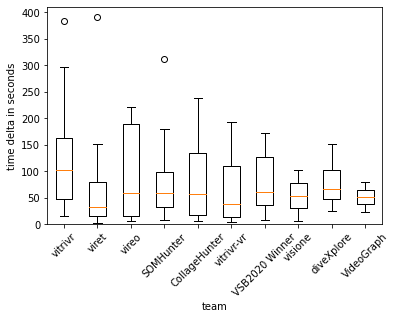

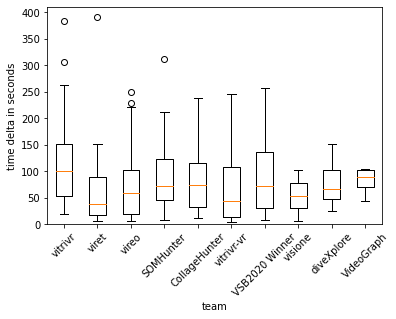

In [167]:
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

shot_deltas = []
shot_deltas.append(delta_shot_vitrivr)
shot_deltas.append(delta_shot_viret)
shot_deltas.append(delta_shot_vireo)
shot_deltas.append(delta_shot_som)
shot_deltas.append(delta_shot_collage_hunter)
shot_deltas.append(delta_shot_vitrivr_vr)
shot_deltas.append(delta_shot_legacy_som)
shot_deltas.append(delta_shot_visione)
shot_deltas.append(delta_shot_diveXplore)
shot_deltas.append(delta_shot_video_graph)

plt.boxplot(shot_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.ylim([0,410])
plt.savefig('figs/delta_shots.pdf', format='pdf', bbox_inches="tight")
plt.show()
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

video_deltas = []
video_deltas.append(delta_video_vitrivr)
video_deltas.append(delta_video_viret)
video_deltas.append(delta_video_vireo)
video_deltas.append(delta_video_som)
video_deltas.append(delta_video_collage_hunter)
video_deltas.append(delta_video_vitrivr_vr)
#video_deltas.append(delta_video_verge)
video_deltas.append(delta_video_legacy_som)
video_deltas.append(delta_video_visione)
video_deltas.append(delta_video_diveXplore)
video_deltas.append(delta_video_video_graph)

plt.boxplot(video_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.ylim([0,410])
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.savefig('figs/delta_videos.pdf', format='pdf', bbox_inches="tight")

In [152]:
def get_team_deltas_last_before_correct(team, path_to_team='/Volumes/F-A23/', cutoff=None):

    class InnertTask:
        def  __init__(self, started, ended, correct_video, correct_shot, cst, name) -> None:
            self.name = name
            self.started = started
            self.ended = ended
            self.correct_submission_time = (cst - started) / 1000
            self.correct_video = correct_video
            self.correct_shot = correct_shot
            self.last_found_shot = -1
            self.last_found_video = -1

        def add_ranking(self, results, adjusted_logged_time, vitrivr=False, visione=False, viret=False, somHunter=False, diveXplore=False, cutoff=None):
            for index, result in enumerate(results):
                if vitrivr or diveXplore:
                    videoId = result['item'][2:]
                else:
                    videoId = result['item']
                
                if visione:
                    shotId = result['frame']
                elif somHunter or viret or diveXplore:
                    for segment in v3c1_ids_shots[videoId]:
                        if segment.isWithin(int(result['frame'])):
                            shotId = segment.get_segmentId()
                            break
                else:
                    shotId = result['segment']
                if videoId == self.correct_video:
                    if result['rank'] is None:
                        rank = 0
                    else:
                        rank = result['rank']
                    if somHunter:
                        rank = index
                    if cutoff is not None:
                        if rank > cutoff:
                            return
                    if adjusted_logged_time > self.last_found_video and adjusted_logged_time < self.correct_submission_time:
                        self.last_found_video = adjusted_logged_time
                    if str(shotId) == self.correct_shot:
                        if adjusted_logged_time > self.last_found_shot and adjusted_logged_time < self.correct_submission_time:
                            self.last_found_shot = adjusted_logged_time
                            #print('Correct submission time: ' + str(self.correct_submission_time) + ', Adjusted logged time: ' + str(adjusted_logged_time) + ', first found video: ' + str(self.first_found_video) + ', first found shot: ' + str(self.first_found_shot))

        
        def get_logged_time(self, logged_time):
            return (logged_time - self.started) / 1000

        def get_shot_delta(self):
            return self.correct_submission_time - self.last_found_shot

        def get_video_delta(self):
            return self.correct_submission_time - self.last_found_video

        def timestamp_within(self, timestamp):
            return timestamp >= self.started and timestamp <= self.ended

        def __str__(self) -> str:
            return str(self.correct_video) + ', ' + str(self.correct_shot) + ': ' + str(self.correct_submission_time)

    teamName = team
    
    if teamName == 'SOMHunter':
        teamName = 'SomHunter'
    elif teamName == 'LegacySOMHunter':
        teamName = 'VBS2020 Winner'
    elif teamName == 'CollageHunter':
        teamName = 'SIRET'
    elif teamName == 'viret':
        teamName = 'VIRET'
    
    for t in data['description']['teams']:
        if t['name'] == teamName:
            teamId = t['uid']
            break

    local_tasks = []

    for t in data['tasks']:
        if t['description']['taskGroup']['name'] == 'KIS-Textual' or t['description']['taskGroup']['name'] == 'KIS-Visual':
            cst = -1
            for s in t['submissions']:
                if s['status'] == 'CORRECT' and s['teamId'] == teamId:
                    cst = s['timestamp']
                    break
            videoId = t['description']['target']['item']['name']
            timeshot = int(t['description']['target']['temporalRange']['start']['value'] * 1000)
            shotId = -1
            sorted_list = list(map(int, v3c1_ids[videoId].keys()))
            next_key = 0
            for k in sorted_list:
                iter_key = next_key
                next_key = k
                if timeshot >= iter_key and timeshot < next_key:
                    shotId = v3c1_ids[videoId][str(iter_key)]
                    break
            t = InnertTask(t['started'], t['ended'], videoId, shotId, cst, t['description']['name'])
            local_tasks.append(t)
    
    for root, _, files in os.walk(path_to_team + team):
        for file in files:
            path = os.path.join(root, file)
            if file == '.DS_Store':
                continue
            with open(path) as f:
                ranked_list = json.load(f)
                timestamp = int(os.path.splitext(file)[0])
                for task in local_tasks:
                    if task.timestamp_within(timestamp):
                        adj_logged_time = task.get_logged_time(timestamp)
                        vitrivr = team == 'vitrivr' or team == 'vitrivr-vr' or team == 'Vireo'
                        visione = team == 'VISIONE'
                        somHunter = team == 'CollageHunter' or team == 'LegacySOMHunter' or team == 'SOMHunter'
                        viret = team == 'viret'
                        diveXplore = team == 'diveXplore'
                        task.add_ranking(ranked_list['results'], adj_logged_time, vitrivr, visione, somHunter, viret, diveXplore, cutoff)
                        break

    delta_shot = []
    delta_video = []

    for t in local_tasks:
        shot_delta = t.get_shot_delta()
        video_delta = t.get_video_delta()
        if shot_delta > 0 and t.last_found_shot >= 0:
            delta_shot.append(shot_delta)
        if video_delta > 0 and t.last_found_video >= 0:
            delta_video.append(video_delta)

    return delta_shot, delta_video

In [53]:
team = 'vitrivr'
delta_shot_bc_vitrivr, delta_video_bc_vitrivr = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)
team = 'vitrivr-vr'
delta_shot_bc_vitrivr_vr, delta_bc_video_vitrivr_vr = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)
team = 'VideoGraph'
delta_shot_bc_video_graph, delta_video_bc_video_graph = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)
team = 'VERGE'
delta_shot_bc_verge, delta_video_bc_verge = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)
team = 'VISIONE'
delta_shot_bc_visione, delta_video_bc_visione = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)
team = 'viret'
delta_shot_bc_viret, delta_video_bc_viret = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)
team = 'CollageHunter'
delta_shot_bc_collage_hunter, delta_video_bc_collage_hunter = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/dres/')
print(team)
team = 'LegacySOMHunter'
delta_shot_bc_legacy_som, delta_video_bc_legacy_som = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/dres/')
print(team)
team = 'SOMHunter'
delta_shot_bc_som, delta_video_bc_som = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/dres/')
print(team)
team = 'Vireo'
delta_shot_bc_vireo, delta_video_bc_vireo = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)
team = 'diveXplore'
delta_shot_bc_diveXplore, delta_video_bc_diveXplore = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/')
print(team)

vitrivr
vitrivr-vr
VideoGraph
VERGE
VISIONE
viret
CollageHunter
LegacySOMHunter
SOMHunter
Vireo


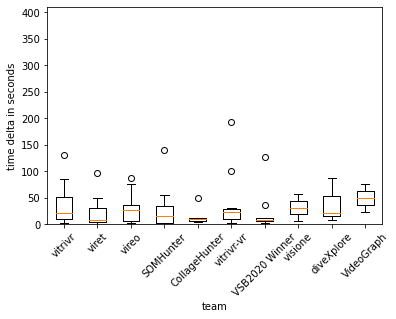

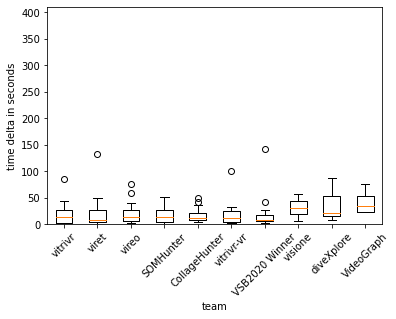

In [136]:
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

shot_deltas = []
shot_deltas.append(delta_shot_bc_vitrivr)
shot_deltas.append(delta_shot_bc_viret)
shot_deltas.append(delta_shot_bc_vireo)
shot_deltas.append(delta_shot_bc_som)
shot_deltas.append(delta_shot_bc_collage_hunter)
shot_deltas.append(delta_shot_bc_vitrivr_vr)
#shot_deltas.append(delta_shot_bc_verge)
shot_deltas.append(delta_shot_bc_legacy_som)
shot_deltas.append(delta_shot_bc_visione)
shot_deltas.append(delta_shot_bc_diveXplore)
shot_deltas.append(delta_shot_bc_video_graph)

plt.boxplot(shot_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.ylim([0,410])
plt.savefig('figs/delta_shots_bc.pdf', format='pdf', bbox_inches="tight")
plt.show()
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

video_deltas = []
video_deltas.append(delta_video_bc_vitrivr)
video_deltas.append(delta_video_bc_viret)
video_deltas.append(delta_video_bc_vireo)
video_deltas.append(delta_video_bc_som)
video_deltas.append(delta_video_bc_collage_hunter)
video_deltas.append(delta_bc_video_vitrivr_vr)
#video_deltas.append(delta_video_bc_verge)
video_deltas.append(delta_video_bc_legacy_som)
video_deltas.append(delta_video_bc_visione)
video_deltas.append(delta_video_bc_diveXplore)
video_deltas.append(delta_video_bc_video_graph)

plt.boxplot(video_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.ylim([0,410])
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.savefig('figs/delta_videos_bc.pdf', format='pdf', bbox_inches="tight")

## Same as the ones before with cutoff:

In [149]:
team = 'vitrivr'
delta_shot_vitrivr_c, delta_video_vitrivr_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)
team = 'vitrivr-vr'
delta_shot_vitrivr_vr_c, delta_video_vitrivr_vr_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)
team = 'VideoGraph'
delta_shot_video_graph_c, delta_video_video_graph_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)
team = 'VERGE'
delta_shot_verge_c, delta_video_verge_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)
team = 'VISIONE'
delta_shot_visione_c, delta_video_visione_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)
team = 'viret'
delta_shot_viret_c, delta_video_viret_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)
team = 'CollageHunter'
delta_shot_collage_hunter_c, delta_video_collage_hunter_c = get_team_deltas(team, '/Volumes/F-A23/dres/', 300)
print(team)
team = 'LegacySOMHunter'
delta_shot_legacy_som_c, delta_video_legacy_som_c = get_team_deltas(team, '/Volumes/F-A23/dres/', 300)
print(team)
team = 'SOMHunter'
delta_shot_som_c, delta_video_som_c = get_team_deltas(team, '/Volumes/F-A23/dres/', 300)
print(team)
team = 'Vireo'
delta_shot_vireo_c, delta_video_vireo_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)
team = 'diveXplore'
delta_shot_diveXplore_c, delta_video_diveXplore_c = get_team_deltas(team, '/Volumes/F-A23/', 300)
print(team)

vitrivr
vitrivr-vr
VideoGraph
VERGE
VISIONE
viret
CollageHunter
LegacySOMHunter
SOMHunter
Vireo
diveXplore


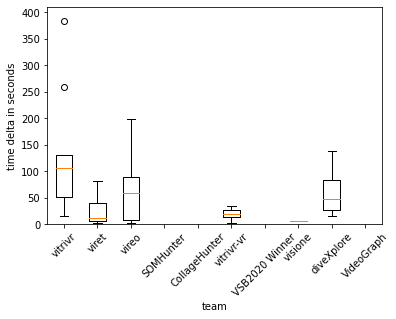

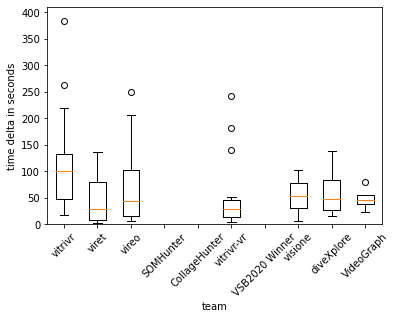

In [168]:
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

shot_deltas = []
shot_deltas.append(delta_shot_vitrivr_c)
shot_deltas.append(delta_shot_viret_c)
shot_deltas.append(delta_shot_vireo_c)
shot_deltas.append(delta_shot_som_c)
shot_deltas.append(delta_shot_collage_hunter_c)
shot_deltas.append(delta_shot_vitrivr_vr_c)
shot_deltas.append(delta_shot_legacy_som_c)
shot_deltas.append(delta_shot_visione_c)
shot_deltas.append(delta_shot_diveXplore_c)
shot_deltas.append(delta_shot_video_graph_c)

plt.boxplot(shot_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.ylim([0,410])
plt.savefig('figs/delta_shots_c300.pdf', format='pdf', bbox_inches="tight")
plt.show()
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

video_deltas = []
video_deltas.append(delta_video_vitrivr_c)
video_deltas.append(delta_video_viret_c)
video_deltas.append(delta_video_vireo_c)
video_deltas.append(delta_video_som_c)
video_deltas.append(delta_video_collage_hunter_c)
video_deltas.append(delta_video_vitrivr_vr_c)
video_deltas.append(delta_video_legacy_som_c)
video_deltas.append(delta_video_visione_c)
video_deltas.append(delta_video_diveXplore_c)
video_deltas.append(delta_video_video_graph_c)

plt.boxplot(video_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.ylim([0,410])
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.savefig('figs/delta_videos_c300.pdf', format='pdf', bbox_inches="tight")

In [153]:
team = 'vitrivr'
delta_shot_bc_vitrivr_c, delta_video_bc_vitrivr_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)
team = 'vitrivr-vr'
delta_shot_bc_vitrivr_vr_c, delta_bc_video_vitrivr_vr_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)
team = 'VideoGraph'
delta_shot_bc_video_graph_c, delta_video_bc_video_graph_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)
team = 'VERGE'
delta_shot_bc_verge_c, delta_video_bc_verge_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)
team = 'VISIONE'
delta_shot_bc_visione_c, delta_video_bc_visione_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)
team = 'viret'
delta_shot_bc_viret_c, delta_video_bc_viret_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)
team = 'CollageHunter'
delta_shot_bc_collage_hunter_c, delta_video_bc_collage_hunter_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/dres/', 300)
print(team)
team = 'LegacySOMHunter'
delta_shot_bc_legacy_som_c, delta_video_bc_legacy_som_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/dres/', 300)
print(team)
team = 'SOMHunter'
delta_shot_bc_som_c, delta_video_bc_som_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/dres/', 300)
print(team)
team = 'Vireo'
delta_shot_bc_vireo_c, delta_video_bc_vireo_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)
team = 'diveXplore'
delta_shot_bc_diveXplore_c, delta_video_bc_diveXplore_c = get_team_deltas_last_before_correct(team, '/Volumes/F-A23/', 300)
print(team)

vitrivr
vitrivr-vr
VideoGraph
VERGE
VISIONE
viret
CollageHunter
LegacySOMHunter
SOMHunter
Vireo
diveXplore


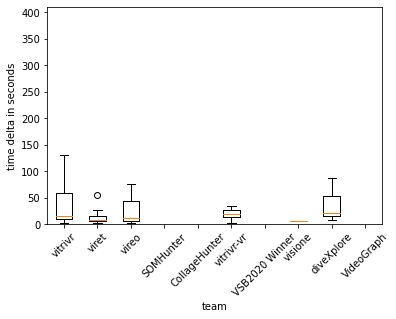

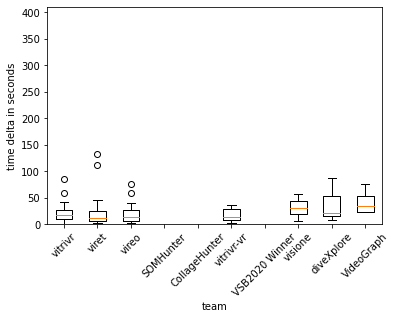

In [169]:
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

shot_deltas = []
shot_deltas.append(delta_shot_bc_vitrivr_c)
shot_deltas.append(delta_shot_bc_viret_c)
shot_deltas.append(delta_shot_bc_vireo_c)
shot_deltas.append(delta_shot_bc_som_c)
shot_deltas.append(delta_shot_bc_collage_hunter_c)
shot_deltas.append(delta_shot_bc_vitrivr_vr_c)
#shot_deltas.append(delta_shot_bc_verge_c)
shot_deltas.append(delta_shot_bc_legacy_som_c)
shot_deltas.append(delta_shot_bc_visione_c)
shot_deltas.append(delta_shot_bc_diveXplore_c)
shot_deltas.append(delta_shot_bc_video_graph_c)

plt.boxplot(shot_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.ylim([0,410])
plt.savefig('figs/delta_shots_bc_c300.pdf', format='pdf', bbox_inches="tight")
plt.show()
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

video_deltas = []
video_deltas.append(delta_video_bc_vitrivr_c)
video_deltas.append(delta_video_bc_viret_c)
video_deltas.append(delta_video_bc_vireo_c)
video_deltas.append(delta_video_bc_som_c)
video_deltas.append(delta_video_bc_collage_hunter_c)
video_deltas.append(delta_bc_video_vitrivr_vr_c)
#video_deltas.append(delta_video_bc_verge_c)
video_deltas.append(delta_video_bc_legacy_som_c)
video_deltas.append(delta_video_bc_visione_c)
video_deltas.append(delta_video_bc_diveXplore_c)
video_deltas.append(delta_video_bc_video_graph_c)

plt.boxplot(video_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.ylim([0,410])
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.savefig('figs/delta_videos_bc_c300.pdf', format='pdf', bbox_inches="tight")

## AVS Judging statistics

In [57]:
class Judge:
    def __init__(self, name) -> None:
        self.name = name
        self.sessions = dict()
        self.nr_correct = 0
        self.nr_wrong = 0
        self.nr_undecidable = 0

    def add_session(self, sessionId):
        self.sessions[sessionId] = True

    def is_session_user(self, sessionId):
        return sessionId in self.sessions

    def add_wrong(self):
        self.nr_wrong += 1

    def add_correct(self):
        self.nr_correct += 1

    def add_indeterminate(self):
        self.nr_undecidable += 1

    def add_status(self, status):
        if status == 'CORRECT':
            self.add_correct()
        elif status == 'WRONG':
            self.add_wrong()
        elif status == 'UNDECIDABLE':
            self.add_indeterminate()
    

judges = dict()

for a in audit:
    if a['type'] == 'LOGIN':
        if 'judge' in a['user']:
            if a['user'] in judges:
                judges[a['user']].add_session(a['session'])
            else:
                judges[a['user']] = Judge(a['user'])
                judges[a['user']].add_session(a['session'])

for a in audit:
    if a['type'] == 'JUDGEMENT':
        for judge in judges:
            if judges[judge].is_session_user(a['user']):
                judges[judge].add_status(a['verdict'])

judges_names = judges.keys()
nr_correct = []
nr_wrong = []
nr_indeterminate = []
percentage_correct = []
for judge in judges:
    nr_correct.append(judges[judge].nr_correct)
    nr_wrong.append(judges[judge].nr_wrong)
    nr_indeterminate.append(judges[judge].nr_undecidable)
    if judges[judge].nr_correct + judges[judge].nr_wrong + judges[judge].nr_undecidable > 0:
        percentage_correct.append((judges[judge].nr_correct / (judges[judge].nr_correct + judges[judge].nr_wrong + judges[judge].nr_undecidable)) * 100)
    else:
        percentage_correct.append(None)

df_dict = dict()
df_dict['judges'] = judges_names
df_dict['Judged as correct'] = nr_correct
df_dict['Judged as wrong'] = nr_wrong
df_dict['Judged as undecidable'] = nr_indeterminate
df_dict['Percentage judged as correct'] = percentage_correct

df = pd.DataFrame(data=df_dict)
df.to_latex('./tex/avs_judgement_statistics.tex')


In [ ]:
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

shot_deltas = []
shot_deltas.append(delta_shot_bc_vitrivr)
shot_deltas.append(delta_shot_bc_viret)
shot_deltas.append(delta_shot_bc_vireo)
shot_deltas.append(delta_shot_bc_som)
shot_deltas.append(delta_shot_bc_collage_hunter)
shot_deltas.append(delta_shot_bc_vitrivr_vr)
#shot_deltas.append(delta_shot_bc_verge)
shot_deltas.append(delta_shot_bc_legacy_som)
shot_deltas.append(delta_shot_bc_visione)
shot_deltas.append(delta_shot_bc_diveXplore)
shot_deltas.append(delta_shot_bc_video_graph)

plt.boxplot(shot_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.ylim([0,410])
plt.savefig('figs/delta_shots_bc_c300.pdf', format='pdf', bbox_inches="tight")
plt.show()
plot_teams = ['vitrivr', 'viret', 'vireo', 'SOMHunter', 'CollageHunter',
    'vitrivr-vr', 'VSB2020 Winner', 'visione', 'diveXplore', 'VideoGraph']

video_deltas = []
video_deltas.append(delta_video_bc_vitrivr)
video_deltas.append(delta_video_bc_viret)
video_deltas.append(delta_video_bc_vireo)
video_deltas.append(delta_video_bc_som)
video_deltas.append(delta_video_bc_collage_hunter)
video_deltas.append(delta_bc_video_vitrivr_vr)
#video_deltas.append(delta_video_bc_verge)
video_deltas.append(delta_video_bc_legacy_som)
video_deltas.append(delta_video_bc_visione)
video_deltas.append(delta_video_bc_diveXplore)
video_deltas.append(delta_video_bc_video_graph)

plt.boxplot(video_deltas)
plt.ylabel('time delta in seconds')
plt.xlabel('team')
plt.ylim([0,410])
plt.xticks([i + 1 for i in range(10)], plot_teams)
plt.xticks(rotation=45)
plt.savefig('figs/delta_videos_bc_c300.pdf', format='pdf', bbox_inches="tight")

## Time delta between prepare judgement and judgement

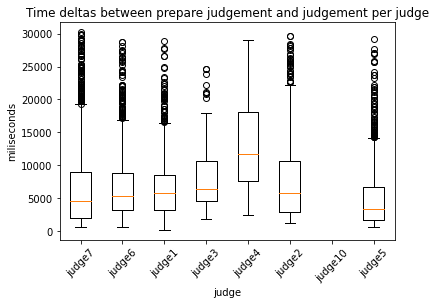

In [56]:
class Judge:
    def __init__(self, name) -> None:
        self.name = name
        self.sessions = dict()
        self.nr_correct = 0
        self.nr_wrong = 0
        self.nr_undecidable = 0
        self.deltas = []

    def add_session(self, sessionId):
        self.sessions[sessionId] = True

    def is_session_user(self, sessionId):
        return sessionId in self.sessions

    def add_wrong(self):
        self.nr_wrong += 1

    def add_correct(self):
        self.nr_correct += 1

    def add_indeterminate(self):
        self.nr_undecidable += 1

    def add_status(self, status):
        if status == 'CORRECT':
            self.add_correct()
        elif status == 'WRONG':
            self.add_wrong()
        elif status == 'UNDECIDABLE':
            self.add_indeterminate()

    def add_delta(self, delta):
        self.deltas.append(delta)

judges = dict()

for a in audit:
    if a['type'] == 'LOGIN':
        if 'judge' in a['user']:
            if a['user'] in judges:
                judges[a['user']].add_session(a['session'])
            else:
                judges[a['user']] = Judge(a['user'])
                judges[a['user']].add_session(a['session'])


prep_judgements = dict()

for a in audit:
    if a['type'] == 'PREPARE_JUDGEMENT':
        prep_judgements[a['token']] = a['timestamp']

for a in audit:
    if a['type'] == 'JUDGEMENT':
        for j in judges:
            if judges[j].is_session_user(a['user']):
                judges[j].add_delta(a['timestamp'] - prep_judgements[a['token']])

judges_names = []
judge_deltas = []

for j in judges:
    judges_names.append(judges[j].name)
    judge_deltas.append(judges[j].deltas)

plt.boxplot(judge_deltas)
plt.ylabel('miliseconds')
plt.xlabel('judge')
plt.title('Time deltas between prepare judgement and judgement per judge')
plt.xticks([i + 1 for i in range(8)], judges_names)
plt.xticks(rotation=45)
plt.savefig('figs/delta_judges_times.pdf', format='pdf', bbox_inches="tight")